# PyTorch Computer Vision

## Computer vision libraries in PyTorch

* [`torchvision`](https://pytorch.org/vision/stable/index.html) - base domain library of PyTorch Computer Vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvison.models` - get pretrained computer vision models that you can leverage for you own problems
* `torchvison.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creaters a Python iterable over a dataset

In [1]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets,models,transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
torch.__version__,torchvision.__version__

('1.9.1', '0.10.1')

## Dataset

The dataset we'll be using is FashionMNIST

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(root="data/03/",train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="data/03/",train=False,download=True,transform=transforms.ToTensor())


/media/indika/Sync/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
len(train_data),len(test_data)

(60000, 10000)

In [5]:
# See the first training example
image,label = train_data[0]

In [6]:
image.shape,label

(torch.Size([1, 28, 28]), 9)

In [7]:
class_names = train_data.classes

In [8]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
class_to_idx = train_data.class_to_idx

In [10]:
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [11]:
image.shape,label # C,H,W

(torch.Size([1, 28, 28]), 9)

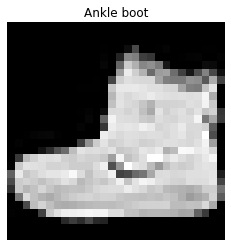

In [12]:
plt.imshow(image.view(28,28,1),cmap="gray")
plt.title(class_names[label])
plt.axis(False);

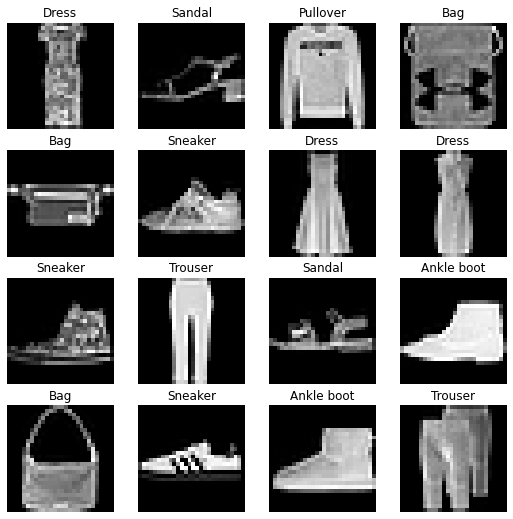

In [13]:
# Plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
row,cols = 4,4
for i in range(1,row*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img,label = train_data[random_idx]
    fig.add_subplot(row,cols,i)
    plt.imshow(img.view(28,28,1),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## PrePare DataLoader

Currently the data is inform of PyTorch Datasets

DataLoader turns our data to a Python iterable

We will turn out data into mini batches

Why?
- Computationally efficent
- Neural network can change the gradient more times, it can change the weights and biases every batch rather than only once per epoch

In [14]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)

In [15]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

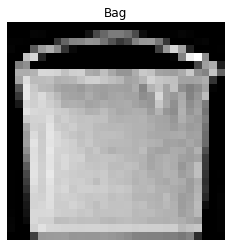

In [16]:
rdm_idx = torch.randint(0,len(train_features_batch),size = [1]).item()
img,label = train_features_batch[rdm_idx],train_labels_batch[rdm_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiement, its best to start with a baseline model

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten()
x = train_features_batch[0]
x.shape,flatten_model(x).shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [18]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,input_shape:int,hidden_units: int, output_shape:int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # No learning parameters
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    
    def forward(self,X) -> torch.Tensor():
        return self.layer_stack(X)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
torch.manual_seed(42)

# Setup model with input parameters

model_0 = FashionMNISTModelV0(input_shape=28*28,hidden_units=10,output_shape=len(class_names))

In [21]:
optimizer = optim.Adam(model_0.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [22]:
dummy_X = torch.rand([1,1,28,28])
model_0(dummy_X)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward>)

### Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi class data, our loss function with be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer is gonna be SGD but I am gonna use Adam() ;)
* For evaluation we are gonan be using accuracy

In [23]:
from helper_functions import *

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(),lr=0.01)

### Creating a function to time our experiments

Machine learning is very experimental

2 of the main things we would want to track are:
1. Model's performence
2. How fast the model runs

In [25]:
from timeit import default_timer as timer

In [26]:
def print_train_time(start:float, end:float, device:torch.device = None):
    total_time = end - start
    print(f"Process took - {total_time}")

In [27]:
start_time = timer()
# some code..
end_time = timer()
print_train_time(start=start_time,end=end_time)

Process took - 1.6349999896192458e-05


### Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches,perform training steps, calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate test loss per batch
4. Print out what's happening
5. Time it all

In [28]:
from tqdm.auto import tqdm

In [29]:
epochs = 3

In [30]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer() 

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)
    
    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()
    
    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
  
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode(): 
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5645 | Test loss: 0.5094, Test acc: 82.2484
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4979 | Test loss: 0.5246, Test acc: 81.7192
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4819 | Test loss: 0.5102, Test acc: 82.9573
Process took - 27.61618622600008


## Make predicitions and get Model 0 results

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
def eval_model(model:torch.nn.Module, 
               data_loader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module,
               accuracy_fn,
               train_or_loss:str):
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            preds = model(X.to(device))
            f_preds = torch.argmax(preds,dim=1)
            loss += loss_fn(preds.to(device),y.to(device))
            acc += accuracy_fn(y_true=y.to(device),y_pred=f_preds.to(device))
        # Scale loss and acc to find average loss/acc per batch
        loss = loss / len(data_loader)
        acc = acc / len(data_loader)
    return {f"{train_or_loss} model_loss":loss.item(),f"{train_or_loss} model_acc":acc} # "model_name":model.__class__.__name__,

In [33]:
# eval_model(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,train_or_loss="test")

In [34]:
# eval_model(model=model_0,data_loader=train_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,train_or_loss="train")

## Setup device agnostic code

In [35]:
!nvidia-smi

Sun Jul  2 17:16:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:26:00.0  On |                  N/A |
|  0%   46C    P8    10W / 170W |    695MiB / 12288MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
# Batchnorm is before activation
class FashionMNIST01(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28,512)
        self.batchnorm1d = nn.BatchNorm1d(512,affine=True)
        self.linear2 = nn.Linear(512,1024)
        self.batchnorm2d = nn.BatchNorm1d(1024,affine=True)
        self.linear3 = nn.Linear(1024,2048)
        self.batchnorm3d = nn.BatchNorm1d(2048,affine=True)
        self.linear4 = nn.Linear(2048,1024)
        self.batchnorm4d = nn.BatchNorm1d(1024,affine=True)
        self.output = nn.Linear(1024,len(class_names))
    
    def forward(self,X):
        X = self.flatten(X)
        X = self.activation(self.batchnorm1d(self.linear1(X)))
        X = self.activation(self.batchnorm2d(self.linear2(X)))
        X = self.activation(self.batchnorm3d(self.linear3(X)))
        X = self.activation(self.batchnorm4d(self.linear4(X)))
        X = self.output(X)
        return X

In [37]:
model_1 = FashionMNIST01().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(),lr=0.01)
epochs = 100

In [38]:
import wandb

In [39]:
wandb.init(project="03",name="model_1_affine_on")
for epoch in tqdm(range(epochs)):
    for X_batch,y_batch in train_dataloader:
        torch.cuda.empty_cache()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_logits = model_1(X_batch)
        preds = torch.argmax(y_logits,dim=1)
        loss = criterion(y_logits,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log(eval_model(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,train_or_loss="test"))
    wandb.log(eval_model(model=model_1,data_loader=train_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,train_or_loss="train"))
wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


  0%|          | 0/100 [00:00<?, ?it/s]

test model_acc,▁▂▃▆▅▇▇▇▇▇▇▇▇▇▇███▇█▆███▇▇▇█▇███████▇█▇█
test model_loss,▂▂▂▁▁▁▁▁▁▂▂▂▂▂▃▂▄▃▃▃▇▄▄▄▄▃▄▆▅▅▄▇▆▅▆▆█▆▇█
train model_acc,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▆█▇▇███████▇███
train model_loss,██▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▅▂▂▂▂▃▁▁▂▁▁▁▁▁▁▁▂▁▁▁
test model_acc,89.38698
test model_loss,0.9201
train model_acc,98.27
train model_loss,0.05354


In [42]:
def train_step(dataloader:torch.utils.data.DataLoader,model:nn.Module,criterion:torch.nn,optimizer:torch.optim):
    for X_batch,y_batch in dataloader:
        torch.cuda.empty_cache()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_logits = model(X_batch)
        preds = torch.argmax(y_logits,dim=1)
        loss = criterion(y_logits,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [43]:
def test_step(dataloader:torch.utils.data.DataLoader,model:nn.Module,accuracy_fn:accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode(): 
        for X_test, y_test in dataloader:
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss,test_acc

In [44]:
eval_model(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,train_or_loss="test")

{'test model_loss': 0.9226915240287781, 'test model_acc': 89.38698083067092}

In [45]:
eval_model(model=model_1,data_loader=train_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,train_or_loss="train")

{'train model_loss': 0.05354353040456772, 'train model_acc': 98.27}

## Model 2: Building a convolutioanl neural network

CNN's are also know as CovNet

Thry are infamous for their great performence with images

In [51]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=(3,3),padding=2,stride=1),
            nn.ReLU()
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=(3,3),padding=2,stride=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=(3,3),padding=2,stride=1),
            nn.ReLU()
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=(3,3),padding=2,stride=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.linearout = nn.Sequential(
            # nn.Flatten()
            nn.Linear(hidden_units,output_shape),
        )
        
    def forward(self,X):
        X = self.convblock1(X)
        X = self.convblock2(X)
        X = self.convblock3(X)
        X = self.convblock4(X)
        print(X.shape)
        X = self.linearout(X)
        return X

In [52]:
model = TinyVGG(1,10,len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
epochs = 100

### Stepping through `nn.Conv2d`

In [54]:
torch.manual_seed(42)
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

In [55]:
test_image.shape

torch.Size([3, 64, 64])

In [64]:
cov_layer = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=0)

In [65]:
cov_layer(test_image).shape

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [10, 3, 3, 3], but got 3-dimensional input of size [3, 64, 64] instead